In [1]:
import os
import cv2
import random
import torch
import pickle
import numpy as np
from models.resnet import resnet50
from lib.dataset.Ebay_dataset import EbayColor
from PIL import Image
from torchvision import transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline  

### Load dataset and pre-trained model

In [37]:
# Load the dataset
feat_size = (32, 32)
size = (1024, 1024)
# Color codes
color_dict = [[0,0,0], [0,0,255], [165,42,42], [0,128,128],[128,128,128],[255,165,0],[255,192,203],
              [128,0,128],[255,0,0],[255,255,255],[255,255,0]]
transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
data_set = EbayColor('./data/', feat_size, transform)
model = resnet50(False)
model.fc = torch.nn.Linear(1024, 11)

# Evaluation mode for batch normalization freeze
model.eval()
for p in model.parameters():
    p.requires_grad = False

# Load Back bone Module
state_dict = torch.load('./checkpoint/Color_pretrain_272.pth')['state_dict']
new_params = model.state_dict()
new_params.update(state_dict)
model.load_state_dict(new_params)
model = model.cuda()

def predict_color(conv_feat3, model):
    result = np.zeros((64, 64, 3))
    # Iterating through pixels embeddings
    for i in range(conv_feat3.shape[-2]):
        for j in range(conv_feat3.shape[-1]):
            # Penalize the pixels of interests
            pixel_feat = conv_feat3[0, :, i, j]
            pixel_feat = pixel_feat.contiguous().view(1, -1)
            prediction = model.fc(pixel_feat)
            _, predicted = torch.max(prediction.data, 1)
            predicted = predicted.cpu().numpy()[0]
            result[i,j] = [item/255. for item in color_dict[predicted]]
    return result

### Randomly pick one a batch

red


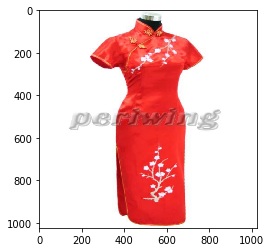

In [43]:
i = random.randint(1,440)
img, mask, color_one_hot, color_single_label = data_set[i]
plt.imshow(img.permute(1,2,0).float().cpu())
image = Variable(img.view(1, img.shape[0], img.shape[1], img.shape[2])).cuda()
print(data_set.labels[color_single_label])

### Pixel-wise prediction

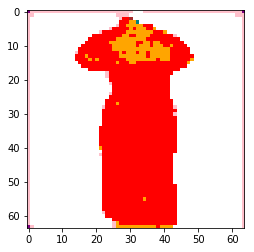

In [44]:
conv_feat3, conv_feat2 = model(image)
result = predict_color(conv_feat3, model)
plt.imshow(result)

### Real image test

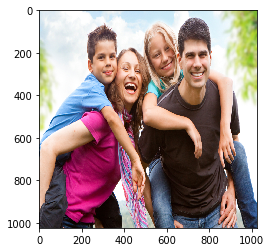

In [46]:
image_path = './images/test2.jpg'
from PIL import Image
image = Image.open(image_path)
# image = torch.from_numpy(np.asarray(image)).float()
size = (1024, 1024)
transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
image = transform(image)
images = Variable(image.view(1,3,1024,1024)).cuda()
conv_feat3, conv_feat2 = model(images)
plt.imshow(images[0].data.permute(1,2,0).float().cpu())

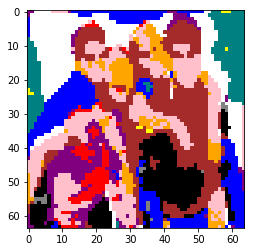

In [49]:
result = predict_color(conv_feat3, model)
plt.imshow(result)